In [2]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
from web3 import Web3, HTTPProvider
import numpy as np
import matplotlib.pyplot as plt


@dataclass
class TokenInfo:
    symbol: str
    address: str

@dataclass
class MarketInfo:
    address: str
    factory_address: str
    llamma: str
    rate: float
    total_debt: float
    n_loans: int
    debt_ceiling: float
    borrowable: float
    pending_fees: float
    collected_fees: float
    collateral_amount: float
    collateral_amount_usd: float
    stablecoin_amount: float
    collateral_token: TokenInfo
    stablecoin_token: TokenInfo



In [3]:
def fetch_curve_markets(chain: str = "ethereum", page: int = 1, per_page: int = 10) -> Dict:
    """
    Fetch crvUSD market data from Curve API
    """
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}"
    params = {
        "fetch_on_chain": "false",
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise exception for bad status codes
    return response.json()

def parse_market_data(market_data: Dict) -> MarketInfo:
    """
    Parse raw market data into MarketInfo object
    """
    
    w3 = Web3()
    
    return MarketInfo(
        address=w3.to_checksum_address(market_data["address"]),
        factory_address=w3.to_checksum_address(market_data["factory_address"]),
        llamma=w3.to_checksum_address(market_data["llamma"]),
        rate=market_data["rate"],
        total_debt=market_data["total_debt"],
        n_loans=market_data["n_loans"],
        debt_ceiling=market_data["debt_ceiling"],
        borrowable=market_data["borrowable"],
        pending_fees=market_data["pending_fees"],
        collected_fees=market_data["collected_fees"],
        collateral_amount=market_data["collateral_amount"],
        collateral_amount_usd=market_data["collateral_amount_usd"],
        stablecoin_amount=market_data["stablecoin_amount"],
        collateral_token=TokenInfo(
            symbol=market_data["collateral_token"]["symbol"],
            address=w3.to_checksum_address(market_data["collateral_token"]["address"])
        ),
        stablecoin_token=TokenInfo(
            symbol=market_data["stablecoin_token"]["symbol"],
            address=w3.to_checksum_address(market_data["stablecoin_token"]["address"])
        )
    )

def get_markets_df() -> pd.DataFrame:
    """
    Fetch market data and return as a pandas DataFrame
    """
    raw_data = fetch_curve_markets()
    markets = [parse_market_data(market) for market in raw_data["data"]]
    
    # Convert to dictionary format suitable for DataFrame
    markets_dict = {
        "address": [],
        "collateral_token": [],
        "rate": [],
        "total_debt": [],
        "n_loans": [],
        "borrowable": [],
        "collateral_amount": [],
        "collateral_amount_usd": [],
        "pending_fees": [],
        "collected_fees": []
    }
    
    for market in markets:
        markets_dict["address"].append(market.address)
        markets_dict["collateral_token"].append(market.collateral_token.symbol)
        markets_dict["rate"].append(market.rate)
        markets_dict["total_debt"].append(market.total_debt)
        markets_dict["n_loans"].append(market.n_loans)
        markets_dict["borrowable"].append(market.borrowable)
        markets_dict["collateral_amount"].append(market.collateral_amount)
        markets_dict["collateral_amount_usd"].append(market.collateral_amount_usd)
        markets_dict["pending_fees"].append(market.pending_fees)
        markets_dict["collected_fees"].append(market.collected_fees)
    
    return pd.DataFrame(markets_dict)

def get_markets_map() -> Dict[str, MarketInfo]:
    """
    Fetch market data and return as a dictionary mapping addresses to MarketInfo objects
    """
    raw_data = fetch_curve_markets()
    markets_map = {}
    
    for market in raw_data["data"]:
        if market["borrowable"] != 0:
            markets_map[market["collateral_token"]["symbol"]] = parse_market_data(market)

    return markets_map


In [4]:
markets = get_markets_map()
markets

{'wstETH': MarketInfo(address='0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0x37417B2238AA52D0DD2D6252d989E728e8f706e4', rate=0.032969654385967884, total_debt=12508840.186299857, n_loans=85, debt_ceiling=None, borrowable=137494437.9547297, pending_fees=3278.1410295642577, collected_fees=6949295.01963203, collateral_amount=5251.009616338953, collateral_amount_usd=19715084.7876002, stablecoin_amount=20874.032413869943, collateral_token=TokenInfo(symbol='wstETH', address='0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0'), stablecoin_token=TokenInfo(symbol='crvUSD', address='0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E')),
 'WBTC': MarketInfo(address='0x4e59541306910aD6dC1daC0AC9dFB29bD9F15c67', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0xE0438Eb3703bF871E31Ce639bd351109c88666ea', rate=0.02044131503970914, total_debt=19948803.894962903, n_loans=157, debt_ceiling=None, borrowable=180053406.29274133, p

In [5]:
def fetch_liquidation_overview(market_address: str, chain: str = "ethereum") -> Dict:
    """
    Fetch liquidation overview data for a specific crvUSD market
    
    Parameters:
    -----------
    market_address : str
        The market address to fetch data for
    chain : str
        The blockchain network (default: "ethereum")
        
    Returns:
    --------
    Dict containing liquidation metrics including:
        - soft_liquidation_users
        - median_health
        - average_health
        - collat_ratio
        - bad_debt
        - liquidatable_positions
        - liquidatable metrics (debt, stablecoin, collateral) in both raw and USD terms
    """
    # Ensure we're using checksum address
    w3 = Web3()
    market_address = w3.to_checksum_address(market_address)
    
    url = f"https://prices.curve.fi/v1/crvusd/liquidations/{chain}/{market_address}/overview"
    params = {
        "fetch_on_chain": "false"
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    return response.json()



---

In [6]:

def score_bad_debt(bad_debt: float,
                   current_debt: float,
                   method: str = 'quadratic_balanced') -> float:
    """
    Score bad debt ratio with different quadratic interpolation methods
    
    Args:
        bad_debt (float): Amount of bad debt
        current_debt (float): Total current debt
        method (str): Interpolation method:
            - quadratic_balanced: Moderate curve (default)
            - quadratic_conservative: Steeper penalty
            - quadratic_aggressive: More lenient curve
            - quadratic_custom: Customizable steepness
        
    Returns:
        float: Score between 0 and 1
    """
    # Constants
    IGNORE_THRESHOLD = 0.001  # 0.1% of current debt
    CRITICAL_THRESHOLD = 0.01  # 1% of current debt
    
    # Convert to ratio for easier calculation
    bad_debt_ratio = bad_debt / current_debt if current_debt > 0 else 0
    
    # If below ignore threshold, return perfect score
    if bad_debt_ratio <= IGNORE_THRESHOLD:
        return 1.0
    
    # If above critical threshold, return zero
    if bad_debt_ratio >= CRITICAL_THRESHOLD:
        return 0.0
    
    # Normalize the ratio to [0,1] range for interpolation
    x = (bad_debt_ratio - IGNORE_THRESHOLD) / (CRITICAL_THRESHOLD - IGNORE_THRESHOLD)
    
    if method == 'quadratic_balanced':
        # Balanced quadratic curve
        return 1 - x * x*x
        
    else:
        # Default to balanced quadratic
        return 1 - x * x
    
def plot_quadratic_methods(current_debt: float = 1000000):
    """
    Visualize different quadratic scoring methods for bad debt
    """
    # Create range of bad debt values to test
    bad_debt_values = np.linspace(0, current_debt * 0.02, 200)
    
    # Calculate scores for each method
    balanced_scores = [score_bad_debt(bd, current_debt, 'quadratic_balanced') 
                      for bd in bad_debt_values]
    
    # Convert bad debt values to percentages
    x_axis = [bd/current_debt * 100 for bd in bad_debt_values]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.plot(x_axis, balanced_scores, label='Balanced', linewidth=2)
    
    # Add threshold lines
    plt.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5, 
                label='Ignore Threshold (0.1%)')
    plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, 
                label='Critical Threshold (1.0%)')
    
    # Customize the plot
    plt.title('Quadratic Bad Debt Scoring Methods Comparison', fontsize=14, pad=20)
    plt.xlabel('Bad Debt Ratio (%)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set axis limits
    plt.xlim(0, 2)
    plt.ylim(-0.1, 1.1)
    
    plt.tight_layout()
    plt.show()


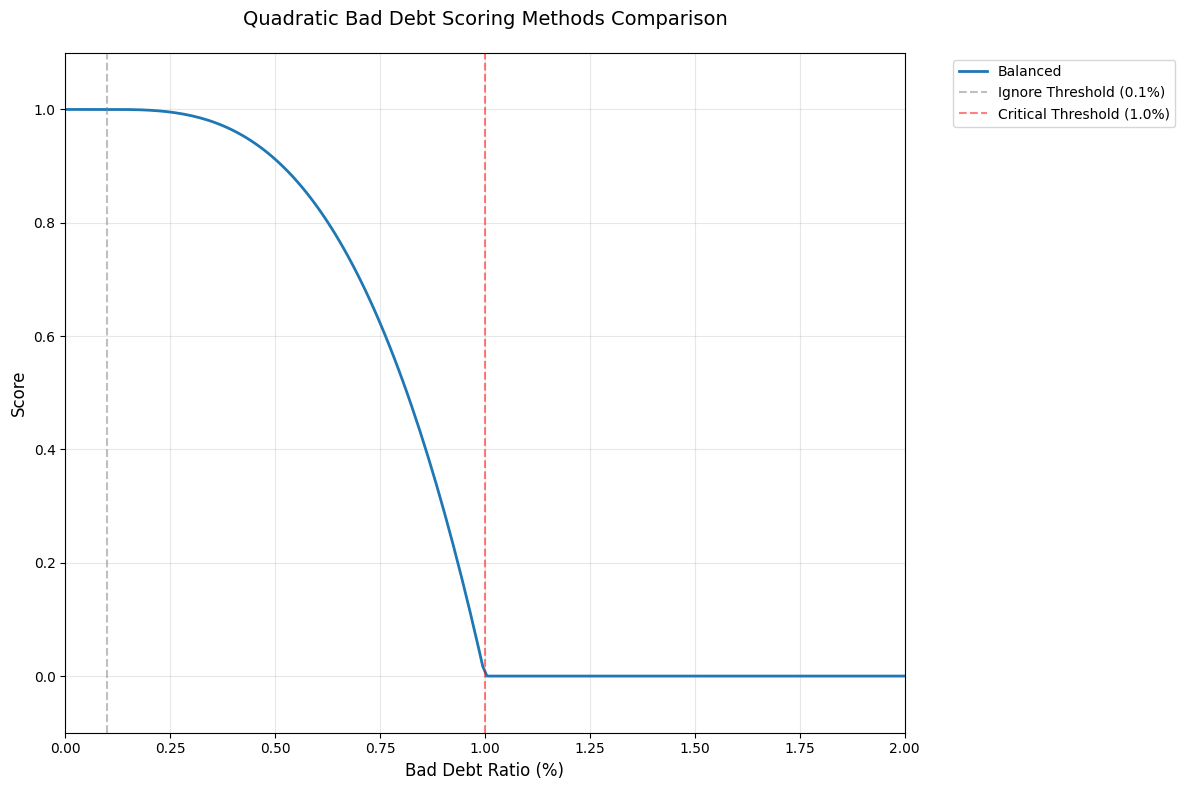

In [7]:
plot_quadratic_methods(1000000)

---

In [8]:
print("\nBAD DEBT SCORING OVERVIEW")
print("=" * 65)
print(f"{'Market':8} | {'Total Debt':>12} | {'Bad Debt':>12} | {'Score':>8}")
print("-" * 65)

for market, info in markets.items():
    total_debt = info.total_debt
    liquidation_data = fetch_liquidation_overview(info.address)
    bad_debt = liquidation_data['bad_debt']
    score = score_bad_debt(bad_debt, total_debt)
    
    # Format numbers for better readability
    total_debt_fmt = f"${total_debt/1e6:.2f}M"
    bad_debt_fmt = f"${bad_debt/1e6:.2f}M"
    
    print(f"{market:8} | {total_debt_fmt:>12} | {bad_debt_fmt:>12} | {score*100:>7.2f}%")

print("=" * 65)


BAD DEBT SCORING OVERVIEW
Market   |   Total Debt |     Bad Debt |    Score
-----------------------------------------------------------------
wstETH   |      $12.51M |       $0.00M |  100.00%
WBTC     |      $19.95M |       $0.00M |  100.00%
WETH     |      $32.55M |       $0.00M |  100.00%
sfrxETH  |       $0.42M |       $0.00M |  100.00%
tBTC     |       $5.49M |       $0.00M |  100.00%
